In [1]:
% matplotlib inline

import time
import os, os.path
import random
import cv2
import glob
import keras
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

import pandas as pd
import numpy as np

Using TensorFlow backend.


In [2]:
DIR = "/home/pranitha/Desktop/animal_images"

def dataset_stats():
    animal_characters = ['C', 'D']
    stats = []
    
    for animal in animal_characters:
        directory_list = sorted(glob.glob("{}/[{}]*".format(DIR, animal)))
        
        for sub_directory in directory_list:
            file_names = [file for file in os.listdir(sub_directory)]
            file_count = len(file_names)
            sub_directory_name = os.path.basename(sub_directory)
            stats.append({ "Code": sub_directory_name[:sub_directory_name.find('-')],
                            "Image count": file_count, 
                           "Folder name": os.path.basename(sub_directory),
                            "File names": file_names})

    df = pd.DataFrame(stats)
    return df

In [3]:
dataset = dataset_stats().set_index("Code")
dataset[["Folder name", "Image count"]]

Folder name  Image count
Code                                    
C1            C1-Abyssinian          198
C12              C12-Sphynx          200
C7            C7-Maine_coon          200
C8               C8-Persian          200
D1      D1-American_bulldog          200
D11            D11-Havanese          200
D21    D21-Scottish_terrier          199
D25   D25-Yorkshire_terrier          200
D9    D9-German_shorthaired          200

In [4]:
def load_images(codes):
    images = []
    labels = []
    for code in codes:
        folder_name = dataset.loc[code]["Folder name"]
        for file in dataset.loc[code]["File names"]:
            file_path = os.path.join(DIR, folder_name, file)
            image = cv2.imread(file_path)
            image = cv2.resize(image, (224,224))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            images.append(image)
            labels.append(code)
    return images, labels

In [5]:
codes = ["C1","C8","D9","D25"]
images, labels = load_images(codes)

In [6]:
def show_random_images(images, labels, number_of_images_to_show=2):
    for code in list(set(labels)):
        indicies = [i for i, label in enumerate(labels) if label == code]
        random_indicies = [random.choice(indicies) for i in range(number_of_images_to_show)]
        figure, axis = plt.subplots(1, number_of_images_to_show)
        print("{} random images for code {}".format(number_of_images_to_show, code))
        for image in range(number_of_images_to_show):
            axis[image].imshow(images[random_indicies[image]])
        plt.show()

2 random images for code D9


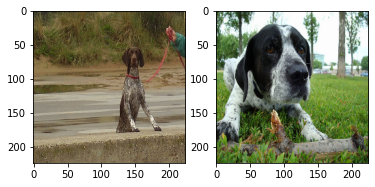

2 random images for code C1


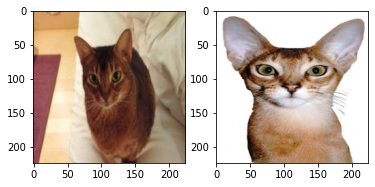

2 random images for code C8


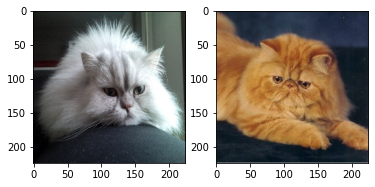

2 random images for code D25


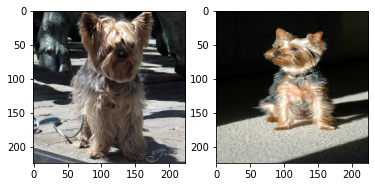

In [7]:
show_random_images(images, labels)

In [8]:
def normalise_images(images, labels):
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels)
    images /= 255
    return images, labels

In [9]:
images, labels = normalise_images(images, labels)

In [10]:
def shuffle_data(images, labels):
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.01, random_state=728)
    return X_train, y_train

In [11]:
X_train, y_train = shuffle_data(images, labels)

In [12]:
import tensorflow 
vgg16_model = tensorflow.keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224,224,3))

vgg19_model = tensorflow.keras.applications.vgg19.VGG19(include_top=False, weights="imagenet", input_shape=(224,224,3))

resnet50_model = tensorflow.keras.applications.resnet50.ResNet50(include_top=False, weights="imagenet", input_shape=(224,224,3))


In [13]:
def covnet_transform(covnet_model, raw_images):
    pred = covnet_model.predict(raw_images)
    flat = pred.reshape(raw_images.shape[0], -1)
    return flat

In [14]:
vgg16_output = covnet_transform(vgg16_model, X_train)
print("VGG16 flattened output has {} features".format(vgg16_output.shape[1]))

vgg19_output = covnet_transform(vgg19_model, X_train)
print("VGG19 flattened output has {} features".format(vgg19_output.shape[1]))

resnet50_output = covnet_transform(resnet50_model, X_train)
print("ResNet50 flattened output has {} features".format(resnet50_output.shape[1]))

VGG16 flattened output has 25088 features
VGG19 flattened output has 25088 features
ResNet50 flattened output has 100352 features


In [15]:
def create_fit_PCA(data, n_components=None):
    p = PCA(n_components=n_components, random_state=728)
    p.fit(data)
    
    return p

In [16]:
vgg16_pca = create_fit_PCA(vgg16_output)
vgg19_pca = create_fit_PCA(vgg19_output)
resnet50_pca = create_fit_PCA(resnet50_output)

In [17]:
vgg16_output_pca = vgg16_pca.transform(vgg16_output)
vgg19_output_pca = vgg19_pca.transform(vgg19_output)
resnet50_output_pca = resnet50_pca.transform(resnet50_output)

In [18]:
print(vgg16_output_pca.shape)
print(vgg19_output_pca.shape)
print(resnet50_output_pca.shape)

(790, 790)
(790, 790)
(790, 790)


In [19]:
def create_train_kmeans(data, number_of_clusters=len(codes)):
    k = KMeans(n_clusters=number_of_clusters, n_jobs=-1, random_state=728)
    start = time.time()
    k.fit(data)
    end = time.time()
    print("Training took {} seconds".format(end-start))
    return k

In [20]:
print("KMeans (PCA): \n")
print("VGG16")
K_vgg16_pca = create_train_kmeans(vgg16_output_pca)
print("\nVGG19")
K_vgg19_pca = create_train_kmeans(vgg19_output_pca)
print("\nResNet50")
K_resnet50_pca = create_train_kmeans(resnet50_output_pca)

KMeans (PCA): 

VGG16


/home/sai/anaconda3/lib/python3.6/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


Training took 1.8001556396484375 seconds

VGG19


/home/sai/anaconda3/lib/python3.6/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


Training took 1.9278244972229004 seconds

ResNet50


/home/sai/anaconda3/lib/python3.6/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


Training took 1.3575658798217773 seconds


In [21]:
# Let's also create models for the covnet outputs without PCA for comparison
print("KMeans: \n")
print("VGG16:")
K_vgg16 = create_train_kmeans(vgg16_output)
print("\nVGG19:")
K_vgg19 = create_train_kmeans(vgg19_output)
print("\nResNet50:")
K_resnet50 = create_train_kmeans(resnet50_output)

KMeans: 

VGG16:


/home/sai/anaconda3/lib/python3.6/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


Training took 24.075404167175293 seconds

VGG19:


/home/sai/anaconda3/lib/python3.6/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


Training took 21.98373532295227 seconds

ResNet50:


/home/sai/anaconda3/lib/python3.6/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


Training took 51.4431734085083 seconds


In [22]:
k_vgg16_pred_pca = K_vgg16_pca.predict(vgg16_output_pca)
k_vgg19_pred_pca = K_vgg19_pca.predict(vgg19_output_pca)
k_resnet50_pred_pca = K_resnet50_pca.predict(resnet50_output_pca)
k_vgg16_pred = K_vgg16.predict(vgg16_output)
k_vgg19_pred = K_vgg19.predict(vgg19_output)
k_resnet50_pred = K_resnet50.predict(resnet50_output)

In [23]:
def cluster_label_count(clusters, labels):
    count = {}
    unique_clusters = list(set(clusters))
    unique_labels = list(set(labels))
    for cluster in unique_clusters:
        count[cluster] = {}
        for label in unique_labels:
            count[cluster][label] = 0
    for i in range(len(clusters)):
        count[clusters[i]][labels[i]] +=1
    cluster_df = pd.DataFrame(count)
    
    return cluster_df

In [24]:
vgg16_cluster_count = cluster_label_count(k_vgg16_pred, y_train)
vgg16_cluster_count_pca = cluster_label_count(k_vgg16_pred_pca, y_train)
vgg19_cluster_count = cluster_label_count(k_vgg19_pred, y_train)
vgg19_cluster_count_pca = cluster_label_count(k_vgg19_pred_pca, y_train)
resnet_cluster_count = cluster_label_count(k_resnet50_pred, y_train)
resnet_cluster_count_pca = cluster_label_count(k_resnet50_pred_pca, y_train)

In [25]:
print("KMeans VGG16(PCA): ")
vgg16_cluster_count_pca

KMeans VGG16(PCA): 


0    1    2    3
C1     4  173    0   19
C8     0   23   16  159
D25   18   23  129   28
D9   148   42    0    8

In [26]:
print("KMeans VGG19 (PCA): ")
vgg19_cluster_count_pca

KMeans VGG19 (PCA): 


0    1    2    3
C1   136    5   49    6
C8    22   31  145    0
D25   27  137   16   18
D9    39    0   22  137

In [27]:
print("Kmeans Resnet50 (PCA): ")
resnet_cluster_count_pca

Kmeans Resnet50 (PCA): 


0   1    2   3
C1   20   8   86  82
C8    4   0  146  48
D25  28  25   50  95
D9   61  45   26  66

In [28]:
print("KMeans VGG16: ")
vgg16_cluster_count

KMeans VGG16: 


0    1    2    3
C1     4  173    0   19
C8     0   23   16  159
D25   18   23  129   28
D9   148   42    0    8

In [29]:
print("KMeans VGG19: ")
vgg19_cluster_count

KMeans VGG19: 


0    1    2    3
C1   136    5   49    6
C8    22   31  145    0
D25   27  137   16   18
D9    39    0   22  137

In [30]:
print("Kmeans Resnet50: ")
resnet_cluster_count

Kmeans Resnet50: 


0   1    2   3
C1   20   8   86  82
C8    4   0  146  48
D25  28  25   50  95
D9   61  45   26  66

In [31]:
#by seeing above matrixes ,it is clearly visible that Resnet 50 does not grouped into correct clusters
#so  i will be removing Resnet 50 
vgg16_cluster_code = ["D9","C1","D25","C8"]
vgg16_cluster_code_pca = ["D9","C1","D25","C8"]
vgg19_cluster_code = ["C1","D25","C8","D9"]
vgg19_cluster_code_pca = ["C1","D25","C8","D9"]

In [32]:
vgg16_pred_codes = [vgg16_cluster_code[x] for x in k_vgg16_pred]
vgg16_pred_codes_pca = [vgg16_cluster_code_pca[x] for x in k_vgg16_pred_pca]
vgg19_pred_codes = [vgg19_cluster_code[x] for x in k_vgg19_pred]
vgg19_pred_codes_pca = [vgg19_cluster_code_pca[x] for x in k_vgg19_pred_pca]

In [33]:
from sklearn.metrics import accuracy_score, f1_score

def print_scores(true, pred):
    acc = accuracy_score(true, pred)
    f1 = f1_score(true, pred, average="macro")
    return "\n\tF1 Score: {0:0.8f}   |   Accuracy: {0:0.8f}".format(f1,acc)

print("KMeans VGG16:", print_scores(y_train, vgg16_pred_codes))
print("KMeans VGG16 (PCA)", print_scores(y_train, vgg16_pred_codes_pca))

print("\nKMeans VGG19: ", print_scores(y_train, vgg19_pred_codes))
print("KMeans VGG19 (PCA): ", print_scores(y_train, vgg19_pred_codes_pca))

KMeans VGG16: 
	F1 Score: 0.77137267   |   Accuracy: 0.77137267
KMeans VGG16 (PCA) 
	F1 Score: 0.77137267   |   Accuracy: 0.77137267

KMeans VGG19:  
	F1 Score: 0.70595333   |   Accuracy: 0.70595333
KMeans VGG19 (PCA):  
	F1 Score: 0.70595333   |   Accuracy: 0.70595333


2 random images for code C12


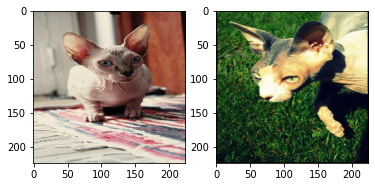

2 random images for code C8


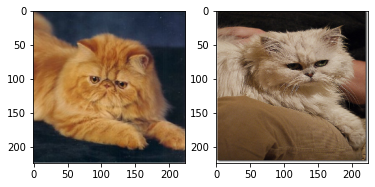

In [34]:
#trying with different images
codes = ["C8","C12"]
images, labels = load_images(codes)
show_random_images(images, labels)

In [35]:
images, labels = normalise_images(images, labels)
X_train, y_train = shuffle_data(images, labels)

In [36]:
vgg16_output = covnet_transform(vgg16_model, X_train)
print("VGG16 flattened output has {} features".format(vgg16_output.shape[1]))

vgg19_output = covnet_transform(vgg19_model, X_train)
print("VGG19 flattened output has {} features".format(vgg19_output.shape[1]))

resnet50_output = covnet_transform(resnet50_model, X_train)
print("ResNet50 flattened output has {} features".format(resnet50_output.shape[1]))

VGG16 flattened output has 25088 features
VGG19 flattened output has 25088 features
ResNet50 flattened output has 100352 features


In [37]:
vgg16_pca = create_fit_PCA(vgg16_output)
vgg19_pca = create_fit_PCA(vgg19_output)
resnet50_pca = create_fit_PCA(resnet50_output)
vgg16_output_pca = vgg16_pca.transform(vgg16_output)
vgg19_output_pca = vgg19_pca.transform(vgg19_output)
resnet50_output_pca = resnet50_pca.transform(resnet50_output)

In [46]:
def create_train_kmean(data, number_of_clusters=2):
    k = KMeans(n_clusters=number_of_clusters, n_jobs=-1, random_state=728)
    start = time.time()
    k.fit(data)
    end = time.time()
    print("Training took {} seconds".format(end-start))
    return k

In [47]:
print("KMeans (PCA): \n")
print("VGG16")
K_vgg16_pca = create_train_kmean(vgg16_output_pca)
print("\nVGG19")
K_vgg19_pca = create_train_kmean(vgg19_output_pca)
print("\nResNet50")
K_resnet50_pca = create_train_kmean(resnet50_output_pca)

KMeans (PCA): 

VGG16
Training took 0.15820050239562988 seconds

VGG19


/home/sai/anaconda3/lib/python3.6/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
/home/sai/anaconda3/lib/python3.6/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


Training took 0.15659379959106445 seconds

ResNet50
Training took 0.10361814498901367 seconds


/home/sai/anaconda3/lib/python3.6/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


In [48]:
k_vgg16_pred_pca = K_vgg16_pca.predict(vgg16_output_pca)
k_vgg19_pred_pca = K_vgg19_pca.predict(vgg19_output_pca)
k_resnet50_pred_pca = K_resnet50_pca.predict(resnet50_output_pca)

In [49]:
vgg16_cluster_count_pca = cluster_label_count(k_vgg16_pred_pca, y_train)
vgg19_cluster_count_pca = cluster_label_count(k_vgg19_pred_pca, y_train)
resnet_cluster_count_pca = cluster_label_count(k_resnet50_pred_pca, y_train)

In [50]:
print("KMeans VGG16(PCA): ")
vgg16_cluster_count_pca

KMeans VGG16(PCA): 


0    1
C12    4  194
C8   192    6

In [51]:
print("KMeans VGG19 (PCA): ")
vgg19_cluster_count_pca

KMeans VGG19 (PCA): 


0    1
C12  179   19
C8     9  189

In [52]:
print("Kmeans Resnet50 (PCA): ")
resnet_cluster_count_pca

Kmeans Resnet50 (PCA): 


0    1
C12  100   98
C8    17  181

In [53]:
vgg16_cluster_code_pca = ["C8", "C12"]
vgg19_cluster_code_pca = ["C12","C8"]

In [54]:
vgg16_pred_codes_pca = [vgg16_cluster_code_pca[x] for x in k_vgg16_pred_pca]
vgg19_pred_codes_pca = [vgg19_cluster_code_pca[x] for x in k_vgg19_pred_pca]

In [55]:
from sklearn.metrics import accuracy_score, f1_score

def print_scores(true, pred):
    acc = accuracy_score(true, pred)
    f1 = f1_score(true, pred, average="macro")
    return "\n\tF1 Score: {0:0.8f}   |   Accuracy: {0:0.8f}".format(f1,acc)

print("KMeans VGG16 (PCA)", print_scores(y_train, vgg16_pred_codes_pca))
print("KMeans VGG19 (PCA): ", print_scores(y_train, vgg19_pred_codes_pca))

KMeans VGG16 (PCA) 
	F1 Score: 0.97474683   |   Accuracy: 0.97474683
KMeans VGG19 (PCA):  
	F1 Score: 0.92924781   |   Accuracy: 0.92924781
